# QUBIC 1D
# Exploring the "Gaussian Peak Approximation"
## JCH - Feb 2025
In this notebook we investigate the issue of TOD realism mentioned in `QUBIC-1D.ipynb`.

## Mandatory Imports

In [13]:
%matplotlib ipympl


import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from importlib import reload    

from qubic.lib import Q1d as q1d 
from qubic.lib.Calibration.Qfiber import profile

sz = 10.
plt.rc('figure',figsize=(sz,sz/1.618))
plt.rc('font',size=10)
plt.rc('image', cmap='jet')

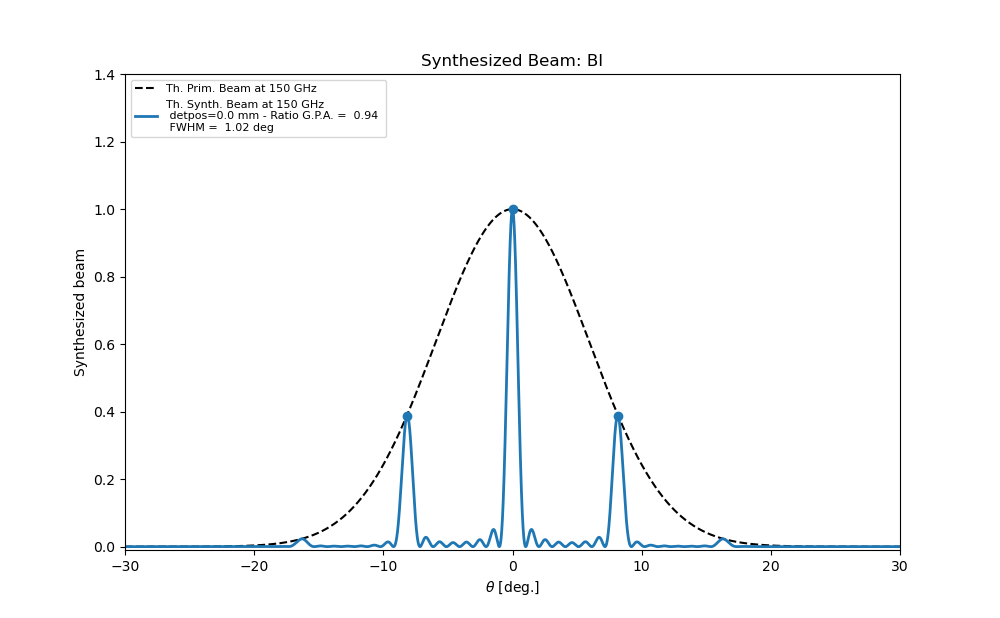

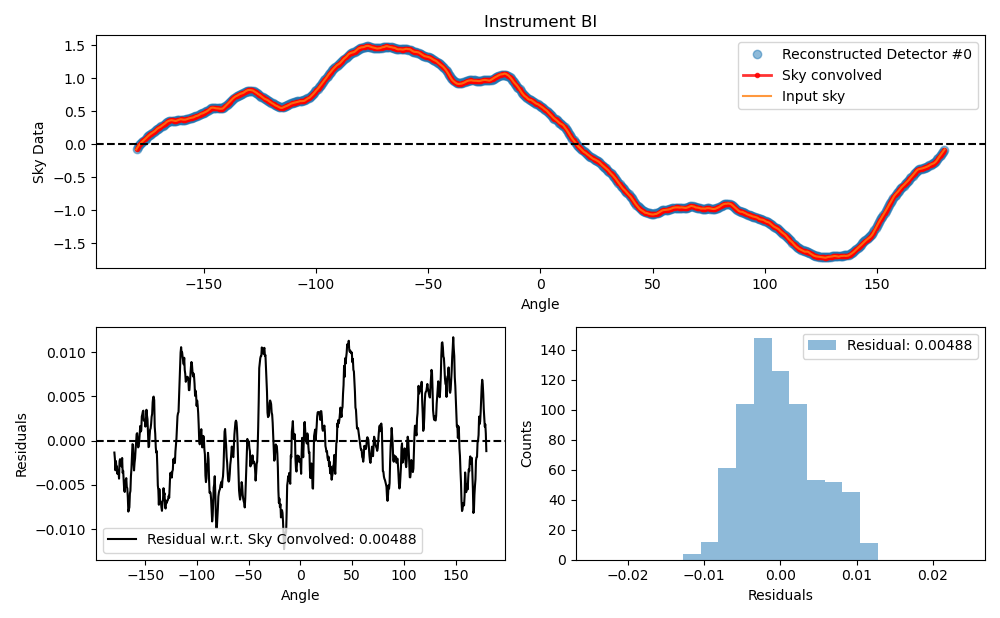

In [22]:
reload(q1d)

params = {'TOD_method':'exact'}
inst_BI = q1d.Q1D(instrument_type='BI', params=params, plot_sb=True)
res = inst_BI.simulate()



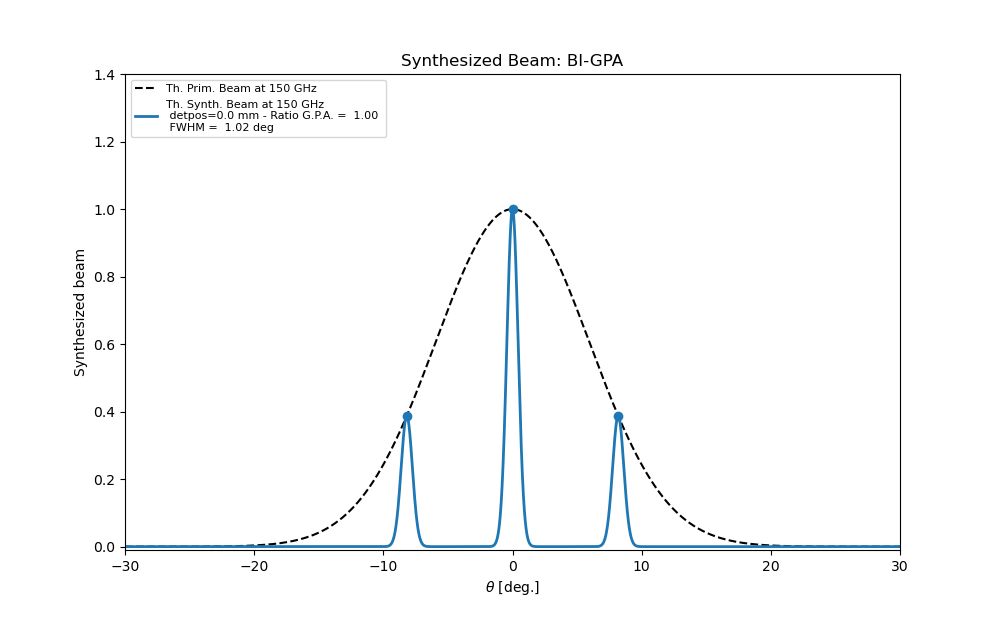

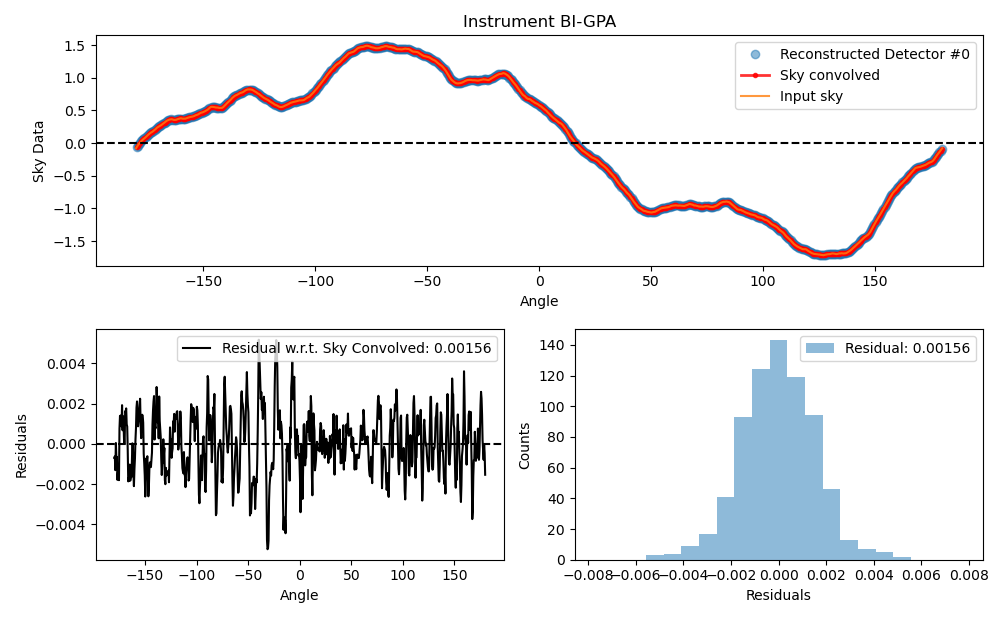

In [23]:

inst_BI_GPA = q1d.Q1D(instrument_type='BI-GPA', params=params, plot_sb=True)
res = inst_BI_GPA.simulate()


## Let's make a Monte-Carlo simulation

In [30]:
reload(q1d)
params = {'plot_sb': False, 
          'plot_reconstructed': False,
          'sky_seed': None,
          'pointing_seed': None,
          'noise_seed': None,
          'noise_rms':0,
          'TOD_method':'exact'}

inst_BI = q1d.Q1D(instrument_type='BI', params=params)
inst_BI_GPA = q1d.Q1D(instrument_type='BI-GPA', params=params)

nn = 30

BI_ps_sky = np.zeros((nn, inst_BI.npix_sky))
BI_ps_sky_pix = np.zeros((nn, inst_BI.npix))
BI_ps_solution = np.zeros((nn, inst_BI.npix))

BI_GPA_ps_sky = np.zeros((nn, inst_BI_GPA.npix_sky))
BI_GPA_ps_sky_pix = np.zeros((nn, inst_BI_GPA.npix))
BI_GPA_ps_solution = np.zeros((nn, inst_BI_GPA.npix))

for i in range(nn):
    print('Realization {}'.format(i))

    #### BI
    results_BI = inst_BI.simulate()
    freq_pix = np.abs(np.fft.fftfreq(len(inst_BI.rec_pix_centers), d=inst_BI.rec_pix_centers[1]-inst_BI.rec_pix_centers[0]))
    freq_sky = np.abs(np.fft.fftfreq(inst_BI.npix_sky, d=inst_BI.input_sky[0][1]-inst_BI.input_sky[0][0]))
    print('    BI     : ',results_BI['RMS_resall'])
    BI_ps_sky_pix[i,:] = np.abs(np.fft.fft(inst_BI.convolved_sky_pix))**2 / len(inst_BI.rec_pix_centers)**2
    BI_ps_solution[i,:] = np.abs(np.fft.fft(results_BI['solution_all']))**2  / len(inst_BI.rec_pix_centers) **2
    BI_ps_sky[i,:] = np.abs(np.fft.fft(inst_BI.input_sky[1]))**2 / inst_BI.npix_sky**2

    results_BI_GPA = inst_BI_GPA.simulate()
    print('    BI-GPA : ',results_BI_GPA['RMS_resall'])
    BI_GPA_ps_sky_pix[i,:] = np.abs(np.fft.fft(inst_BI_GPA.convolved_sky_pix))**2 / len(inst_BI_GPA.rec_pix_centers)**2
    BI_GPA_ps_solution[i,:] = np.abs(np.fft.fft(results_BI_GPA['solution_all']))**2  / len(inst_BI_GPA.rec_pix_centers) **2
    BI_GPA_ps_sky[i,:] = np.abs(np.fft.fft(inst_BI_GPA.input_sky[1]))**2 / inst_BI_GPA.npix_sky**2



Realization 0
    BI     :  0.011092396869614017
    BI-GPA :  0.0012625172334623624
Realization 1
    BI     :  0.0038878183702058763
    BI-GPA :  0.0009216890852155883
Realization 2
    BI     :  0.0022705738455280687
    BI-GPA :  0.0014046149659663928
Realization 3
    BI     :  0.0022784081369615185
    BI-GPA :  0.0009669843058815506
Realization 4
    BI     :  0.004578345584157355
    BI-GPA :  0.0011682664563124735
Realization 5
    BI     :  0.0037341051494937734
    BI-GPA :  0.0019012724713591937
Realization 6
    BI     :  0.006660289752727414
    BI-GPA :  0.0022107666683748024
Realization 7
    BI     :  0.004295265165008422
    BI-GPA :  0.0021822212716465683
Realization 8
    BI     :  0.01322665449727041
    BI-GPA :  0.0017334564821397287
Realization 9
    BI     :  0.0036359900795565076
    BI-GPA :  0.0007569348763247665
Realization 10
    BI     :  0.004018986736696248
    BI-GPA :  0.0022829929596268274
Realization 11
    BI     :  0.0055532053542221415
    BI-GP

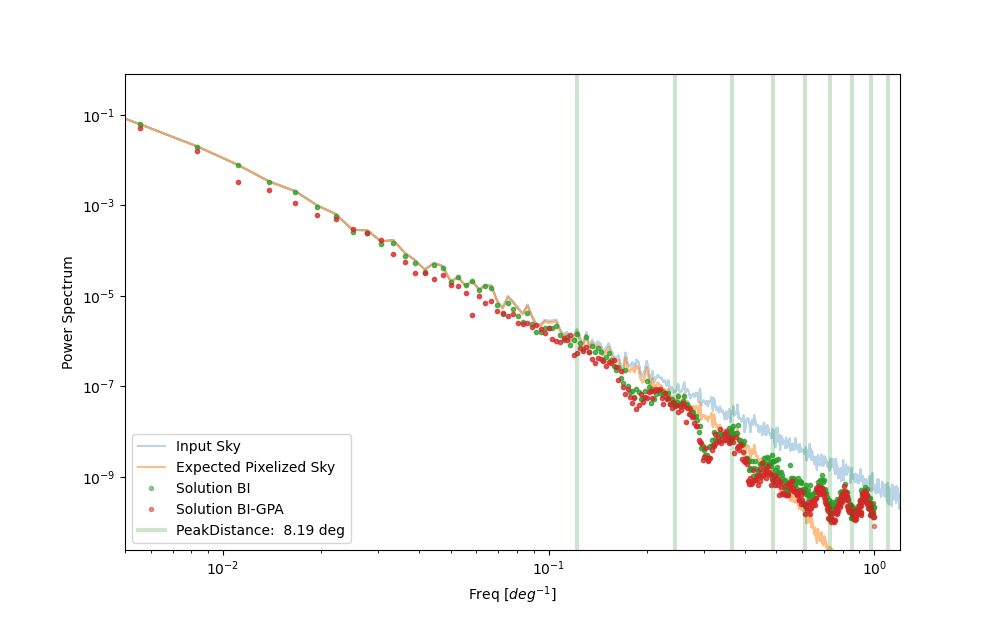

In [37]:
#### Power spectrum analysis

known_freqs = []
dpeaks = inst_BI_GPA.thetapeaks[0][1] - inst_BI_GPA.thetapeaks[0][0]
known_freqs.append({'label':'PeakDistance: {0:5.3g} deg'.format(dpeaks), 'freq': 1./dpeaks, 'color':'g', 'ls':'-', 'lw': 3, 'nbharm': 10})

plt.figure()
plt.plot(freq_sky, np.mean(BI_ps_sky, axis=0), label='Input Sky', alpha=0.3)
plt.plot(freq_pix, np.mean(BI_ps_sky_pix, axis=0), alpha=0.5, label='Expected Pixelized Sky')
plt.plot(freq_pix, np.mean(BI_ps_solution, axis=0), '.', alpha=0.5, label='Solution BI')
plt.plot(freq_pix, np.mean(BI_GPA_ps_solution, axis=0), '.', alpha=0.5, label='Solution BI-GPA')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=0.2, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=0.2)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [$deg^{-1}$]')
plt.ylabel('Power Spectrum')
plt.xlim(5e-3, np.max(freq_pix)*1.2)
plt.ylim(np.min(np.mean(BI_ps_solution, axis=0))/5, np.max(np.mean(BI_ps_solution, axis=0))*2)
plt.legend()


To check next: difference between kmax sim and kmax rec